In [13]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer, XLNetTokenizer, XLNetForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from classes import *
from functions import *

In [2]:
#bert-base-uncased
#distilbert-base-uncased
#xlnet-base-uncased
#roberta-base
#distilroberta-base
model_list = ['bert-base-uncased','distilbert-base-uncased',
              'xlnet-base-uncased',
              'roberta-base','distilroberta-base']

In [3]:
# Select model and parameters and create lebel accordingly
model = model_list[1]
learning_rate = 2e-5
model_name = f'{model}_lr{learning_rate}'

In [4]:
print(model_name)

distilbert-base-uncased_lr2e-05


In [34]:
#load the data
'''train_raw,test_raw,train_label_raw,test_label_raw=[],[],[],[]
with open('../input/train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train_raw.append(line.split('__label__')[1][1:])
    train_label_raw.append(line.split('__label__')[1][0])
with open('../input/test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test_raw.append(line.split('__label__')[1][1:])
    test_label_raw.append(line.split('__label__')[1][0])

#convert data to a dataframe
train = pd.DataFrame({'text': train_raw, 'target': train_label_raw})
test = pd.DataFrame({'text': test_raw, 'target': test_label_raw})
#turn targets into ints
train['target'] = train['target'].astype(int)
test['target'] = test['target'].astype(int)
target_map = {1:0, 2:1}
train['target'] = train['target'].replace(target_map)
test['target'] = test['target'].replace(target_map)'''

file = '../input/amazon_cells_labelled.txt'
df = pd.read_csv(file, delimiter='\t', header=None, names=['text', 'target'])

train_length = int(len(df)*0.8)

train = df[:train_length]
test = df[train_length:]


In [37]:
test.head()

,text,target
800,"Good , works fine.",1
801,For the price this was a great deal.,1
802,"Great price, too!",1
803,"If there is a wind, it is completely useless.",0
804,Yes it's shiny on front side - and I love it!,1


In [38]:
# Moved to classes.py
'''class amazon_dataset(Dataset):
    def __init__(self, encoded_data, labels):
        self.input_ids = encoded_data["input_ids"]
        self.attention_mask = encoded_data["attention_mask"]
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }'''

In [41]:
#set length for training data, this also impacts test length
train_len = 800

train_text = train['text'].to_list()[:train_len]
test_text = test['text'].to_list()[:int(train_len/8)]
train_targets = train['target'].to_list()[:train_len]
test_targets = test['target'].to_list()[:int(train_len/8)]

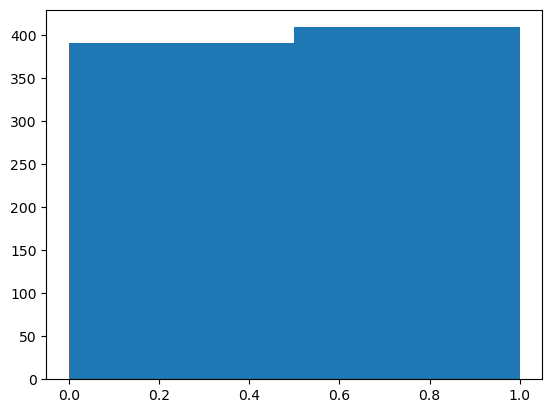

In [45]:
plt.hist(train_targets, bins=2)
plt.show()

In [46]:
# Moved to functions.py
'''def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

    # Let's say we want to train only the classifier layer
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model'''

# Load relevent model and freeze layers. Freezing will result in poor performace in this instance and so should be removed in future iterations. 
# Freezing was done to speed up training time to check the code runs smoothly
if model == 'bert-base-uncased':
    tokenizer = BertTokenizer.from_pretrained(model)
    model = freeze(BertForSequenceClassification.from_pretrained(model, num_labels=2))
elif model == 'distilbert-base-uncased':
    tokenizer = DistilBertTokenizer.from_pretrained(model)
    model = DistilBertForSequenceClassification.from_pretrained(model, num_labels=2)
    
elif model == 'xlnet-base-uncased':
    tokenizer = XLNetTokenizer.from_pretrained(model)
    model = freeze(XLNetForSequenceClassification.from_pretrained(model, num_labels=2))

elif model == 'roberta-base':
    tokenizer = RobertaTokenizer.from_pretrained(model)
    model = freeze(RobertaForSequenceClassification.from_pretrained(model, num_labels=2))
elif model == 'distilroberta-base':
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

else:
    raise Exception('Model not recognised')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [47]:
# Encode the text
train_text_encoded = tokenizer.batch_encode_plus(train_text, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt', max_length=128, return_attention_mask=True)
test_text_encoded = tokenizer.batch_encode_plus(test_text, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt', max_length=128, return_attention_mask=True)


In [48]:
# Load encoded text into datasets and then dataloaders ready for PyTorch
train_dataset = amazon_dataset(train_text_encoded, train_targets)
test_dataset = amazon_dataset(test_text_encoded, test_targets)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [49]:
# Set the processor to the best avalible option
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Using: {device}')
model.to(device)

Using: cpu


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [50]:
optimiser = AdamW(params=model.parameters(), lr=learning_rate)

In [51]:
print(model_name)

distilbert-base-uncased_lr2e-05


In [52]:
# base-bert-cased 391m

# base-bert-uncased 387m
#0.896
#0.8976377952755905

# distilbert-base-cased 200m
#0.808
#0.7894736842105263

# Train the model
epochs = 1

num_training_steps = epochs * len(train_dataloader)
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(epochs):
    for batch in train_dataloader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimiser.zero_grad()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward() 
        optimiser.step()
        progress_bar.update(1)


100%|██████████| 25/25 [26:39<00:00, 63.80s/it]

In [53]:
# Create predictions
preds, true = [], []

for batch in tqdm(test_dataloader):
    with torch.no_grad():
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.eval()

        output = model(inputs, attention_mask=attention_mask)

        logits = output.logits
        predictions = torch.argmax(logits, dim=-1)

        preds.append(predictions.numpy())

        true.append(labels.numpy())


100%|██████████| 4/4 [02:41<00:00, 40.45s/it]


In [54]:
# Flatten the preds
flat_preds = np.concatenate([batch_preds for batch_preds in preds])
flat_true = np.concatenate([batch_true for batch_true in true])


In [56]:
print(flat_preds)
print(flat_true)

[0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
[1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1]


In [57]:
# Poor results due to freezing
from sklearn.metrics import accuracy_score, f1_score

print(accuracy_score(flat_true, flat_preds))
print(f1_score(flat_true, flat_preds))

0.48
0.3333333333333333


In [60]:
# Create directory and save model

import os

output_dir = f'../models/{model_name}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('../models/distilbert-base-uncased_lr2e-05\\tokenizer_config.json',
 '../models/distilbert-base-uncased_lr2e-05\\special_tokens_map.json',
 '../models/distilbert-base-uncased_lr2e-05\\vocab.txt',
 '../models/distilbert-base-uncased_lr2e-05\\added_tokens.json')